taking code from scatterplot.py to try out using matplotlib styles...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# from matplotlib import rc
# # rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc("font",**{"family":"serif","serif":["cmr10"]})
# rc('text', usetex=True)

# rc("xtick", labelsize=10)
# rc("ytick", labelsize=10)

import scipy.odr.odrpack as odrpack
import numpy as np
np.random.seed(1)

# load the very latest version
import sys
sys.path.append("/Users/andyreagan/tools/python/labMTsimple/")
from labMTsimple.speedy import *
from labMTsimple.storyLab import *

sys.path.append("/Users/andyreagan/tools/python/kitchentable/")
# from kitchentable.tools import *
# better namespacing
from dogtoys import *

LabMT_dict = LabMT()
LabMT_trie = LabMT(datastructure='marisatrie',stopVal=0.0)
LIWC_dict = LIWC(stopVal=0.0,bananas=False)
LIWC_trie = LIWC(datastructure='marisatrie',stopVal=0.0,bananas=False)
WK_dict = WK()
ANEW_dict = ANEW()
MPQA_dict = MPQA()
MPQA_trie = MPQA(datastructure='marisatrie')
Liu_dict = OL()
Liu_trie = OL(datastructure='marisatrie')

my_LabMT = LabMT(stopVal=0.0)
my_LIWC = LIWC(stopVal=0.0)
my_WK = WK(stopVal=0.0)
my_ANEW = ANEW(stopVal=0.0)
my_MPQA = MPQA(stopVal=0.0)
my_Liu = OL(stopVal=0.0,datastructure='marisatrie')

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1076: UserWarning: Bad val "upper-left" on line #29
	"legend.loc: upper-left
"
	in file "/Users/andyreagan/.matplotlib/stylelib/paper-twocol.mplstyle"
	Key legend.loc: Unrecognized legend_loc string "upper-left": valid strings are ['upper left', 'upper right', 'right', 'upper center', 'center right', 'lower right', 'lower left', 'center', 'lower center', 'center left', 'best']
  (val, error_details, msg))


In [2]:
def f(B, x):
    return B[0]*x + B[1]

linear = odrpack.Model(f)

In [3]:
def scatter_full_full(x_set,y_set,ax,insetsize=6,tile="A"):
    '''...'''
    overlapWords = []
    overlapScores = []
    overlapScoresStd = []
    for word,index in y_set.data.items():
        if word in x_set.data:
            overlapScores.append((x_set.data[word][1],index[1]))
            overlapScoresStd.append((x_set.data[word][2],index[2]))
            overlapWords.append(word)
    # print(len(overlapWords))
    # print(len(overlapScores))
    # print(len(overlapScoresStd))
    # print(overlapScores[:10])
    # print(overlapScoresStd[:10])
    # print(overlapWords[:10])

    x_setscores = [x[0] for x in overlapScores]
    x_setscoresStd = [x[0] for x in overlapScoresStd]
    # print('median of set 1 is: {0}'.format(np.median(x_setscores)))
    y_setscores = [x[1] for x in overlapScores]
    # print('median of set 2 is: {0}'.format(np.median(y_setscores)))
    # print('which makes the difference: {0}'.format(np.abs(np.median(x_setscores)-np.median(y_setscores))))
    y_setscoresStd = [x[1] for x in overlapScoresStd]
    
    # ordinary least squares
    # mydata = odrpack.RealData(x_setscores, y_setscores) #, sx=sx, sy=sy)
    # RMA
    mydata = odrpack.RealData(x_setscores, y_setscores, sx=x_setscoresStd, sy=y_setscoresStd)

    myodr = odrpack.ODR(mydata, linear, beta0=[1., 0.])
    myoutput = myodr.run()
    myoutput.pprint()
    # print(myoutput.beta)
    # print(myoutput.sd_beta)
    beta = myoutput.beta    
    
    # ax.scatter(x_setscores,y_setscores,alpha=0.25,marker='o',s=6,linewidth=0.2,edgecolor='k')
    ax.scatter(x_setscores,y_setscores,alpha=0.9,marker='o',c='#F0F0FA',s=12,linewidth=0.0,edgecolor='k')
    ax.scatter(x_setscores,y_setscores,alpha=0.9,marker='o',c='#4D4D4D',s=0.7,linewidth=0.0,edgecolor='k')
    # ax.scatter(x_setscores,y_setscores)
    
    x = np.linspace(min(x_setscores),max(x_setscores),num=100)
    ax.plot(x,myoutput.beta[0]*x+myoutput.beta[1],color="#e41a1c")
    # ,'r',linewidth=0.75)
    
    ax.legend([r'RMA $\beta = {0:.2f}, \alpha = {1:.2f}$'.format(myoutput.beta[0],myoutput.beta[1])],loc='upper left') #,fontsize=8)
    # ,loc='upperleft',fontsize=insetsize,frameon=False)
    # \textrm{{RMA}} 

    ax.set_xlabel(x_set.title)
    ax.set_ylabel(y_set.title) #,fontsize=14)
    
    ax.set_xlim([1,9])
    ax.set_ylim([1,9])
#     ax.set_xticks([])
#     ax.set_yticks([])
    
    # mysavefig('WK-LabMT.pdf')

    # let's now go and compute the distance for each word
    absDiff = [np.abs(x[1]-x[0]) for x in overlapScores]

    fitDiff = np.zeros(len(overlapScores))
    for i,scores in zip(range(len(overlapScores)),overlapScores):
        intercept_x = (scores[1]+scores[0]*beta[0]-beta[1])/(2*beta[0])
        intercept_y = beta[0]*intercept_x + beta[1]
        d = np.sqrt((intercept_x-scores[0])**2+(intercept_y-scores[1])**2)
        fitDiff[i] = d

    indexer = sorted(range(len(overlapScores)), key=lambda k: fitDiff[k], reverse=True)
    overlapScoresSorted = [overlapScores[i] for i in indexer]
    overlapWordsSorted = [overlapWords[i] for i in indexer]
    fitDiffSorted = [fitDiff[i] for i in indexer]
    print('sorted by difference from the fit:')
    print(overlapScoresSorted[:10])
    print(overlapWordsSorted[:10])
    print(fitDiffSorted[:10])

#     f = open('txt-output/{0}-{1}-sorted-overlapping-words-fit.csv'.format(x_set.title,y_set.title),'w')
#     f.write('word,score1,score2,diff\n')
#     for scores,word,fitdiff in zip(overlapScoresSorted,overlapWordsSorted,fitDiffSorted):
#         f.write('{0},{1:.2f},{2:.2f},{3:.2f}\n'.format(word,scores[0],scores[1],fitdiff))
#     f.close()

#     f = open('{0}-{1}-sorted-overlapping-words-fit.tex'.format(x_set.title,y_set.title),'w')
#     f.write('\\begin{tabular}[t]{p{1.5cm}|p{1.0cm}|p{1.0cm}|p{1.0cm}}\n')
#     f.write('Word & $h_{{\\text{{ {0} }} }}$ & $h_{{ \\text{{ {1} }} }}$ & $h_{{\\text{{diff}}}}$ \\\\\n\\hline\n'.format(x_set.title,y_set.title))
#     for scores,word,fitdiff in zip(overlapScoresSorted,overlapWordsSorted,fitDiffSorted)[:10]:
#         f.write('{0} & \\centering\\arraybackslash {1:.2f} & \\centering\\arraybackslash {2:.2f} & \\centering\\arraybackslash {3:.2f}\\\\\n'.format(word,scores[0],scores[1],fitdiff))
#     f.write('\\end{tabular}\n')
#     f.close()

#     tabletex_file_to_pdf('{0}-{1}-sorted-overlapping-words-fit.tex'.format(x_set.title,y_set.title))
#     f = open('{0}.tex'.format(tile),'w')
#     f.write('\\begin{tabular}[t]{p{1.5cm}|p{1.0cm}|p{1.0cm}|p{1.0cm}}\n')
#     f.write('Word & $h_{{\\text{{ {0} }} }}$ & $h_{{ \\text{{ {1} }} }}$ & $h_{{\\text{{diff}}}}$ \\\\\n\\hline\n'.format(x_set.title,y_set.title))
#     for scores,word,fitdiff in zip(overlapScoresSorted,overlapWordsSorted,fitDiffSorted)[:10]:
#         f.write('{0} & \\centering\\arraybackslash {1:.2f} & \\centering\\arraybackslash {2:.2f} & \\centering\\arraybackslash {3:.2f}\\\\\n'.format(word,scores[0],scores[1],fitdiff))
#     f.write('\\end{tabular}\n')
#     f.close()
#     tabletex_file_to_pdf('{0}.tex'.format(tile))

#     print('sorted by absolute difference:')
#     indexer = sorted(range(len(overlapScores)), key=lambda k: absDiff[k], reverse=True)
#     overlapScoresSorted = [overlapScores[i] for i in indexer]
#     overlapWordsSorted = [overlapWords[i] for i in indexer]
#     absDiffSorted = [absDiff[i] for i in indexer]
#     print(overlapScoresSorted[:10])
#     print(overlapWordsSorted[:10])
#     print(absDiffSorted[:10])

#     f = open('txt-output/{0}-{1}-sorted-overlapping-words-abs.csv'.format(x_set.title,y_set.title),'w')
#     f.write('word,score1,score2,diff\n')    
#     for scores,word,fitdiff in zip(overlapScoresSorted,overlapWordsSorted,absDiffSorted):
#         f.write('{0},{1:.2f},{2:.2f},{3:.2f}\n'.format(word,scores[0],scores[1],fitdiff))
#     f.close()

#     f = open('{0}-{1}-sorted-overlapping-words-abs.tex'.format(x_set.title,y_set.title),'w')
#     f.write('\\begin{tabular}[t]{p{1.5cm}|p{1.0cm}|p{1.0cm}|p{1.0cm}}\n')
#     f.write('Word & $h_{{\\text{{ {0} }} }}$ & $h_{{ \\text{{ {1} }} }}$ & $h_{{\\text{{diff}}}}$ \\\\\n\\hline\n'.format(x_set.title,y_set.title))    
#     for scores,word,fitdiff in zip(overlapScoresSorted,overlapWordsSorted,fitDiffSorted)[:10]:
#         f.write('{0} & \\centering\\arraybackslash {1:.2f} & \\centering\\arraybackslash {2:.2f} & \\centering\\arraybackslash {3:.2f}\\\\\n'.format(word,scores[0],scores[1],fitdiff))
#     f.write('\\end{tabular}\n')            
#     f.close()

#     tabletex_file_to_pdf('{0}-{1}-sorted-overlapping-words-abs.tex'.format(x_set.title,y_set.title))

In [4]:
# # NO STYLE

# # fig = plt.figure()
# # ax1 = plt.subplot(1,3,1)
# # scatter_full_full(my_LabMT,my_WK,ax1)
# # ax2 = plt.subplot(1,3,2)
# # scatter_full_full(my_ANEW,my_LabMT,ax2)
# # ax3 = plt.subplot(1,3,3)
# # scatter_full_full(my_WK,my_ANEW,ax3)

# fig = plt.figure()
# fig,(ax1,ax2,ax3) = plt.subplots(1,3)
# scatter_full_full(my_LabMT,my_WK,ax1)
# scatter_full_full(my_ANEW,my_LabMT,ax2)
# scatter_full_full(my_WK,my_ANEW,ax3)
# plt.savefig("../figures/PNAS/labMT_WK_ANEW_001.pdf")

Beta: [ 1.03806235 -0.27474809]
Beta Std Error: [ 0.00609628  0.03424976]
Beta Covariance: [[ 0.00068488 -0.00375346]
 [-0.00375346  0.02161738]]
Residual Variance: 0.05426403468864739
Inverse Condition #: 0.0038647016712698504
Reason(s) for Halting:
  Sum of squares convergence
sorted by difference from the fit:
[(4.3, 2.18), (5.86, 3.8), (6.48, 4.5), (4.72, 6.57), (4.94, 3.06), (2.58, 4.19), (4.44, 6.11), (5.04, 6.71), (5.48, 3.67), (4.48, 6.1)]
['sue', 'boogie', 'exclusive', 'wake', 'federal', 'stroke', 'gay', 'patient', 'user', 'blow']
[1.3947212010367698, 1.3942888586005684, 1.3551314263742058, 1.3504089474288816, 1.2450100069011034, 1.2403357419693375, 1.2328404866703147, 1.216985291199866, 1.2106811903885764, 1.1970702647561426]
Beta: [ 0.9227343   0.40284122]
Beta Std Error: [ 0.00885269  0.05204011]
Beta Covariance: [[ 0.00133259 -0.00732506]
 [-0.00732506  0.04604919]]
Residual Variance: 0.058810438118209234
Inverse Condition #: 0.005969665844298161
Reason(s) for Halting:
  S

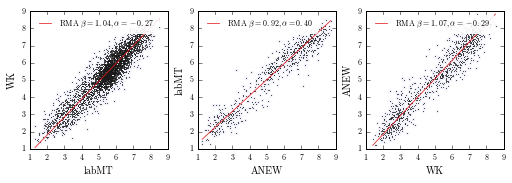

In [5]:
# works locally with the full filename
with plt.style.context(('paper-twocol')):
    fig = plt.figure()
    # fig,(ax1,ax2,ax3) = plt.subplots(1,3)
    spacing = .06
    left = (1-3*spacing)/3
    ax1 = fig.add_axes([spacing,spacing,left,left*2])
    scatter_full_full(my_LabMT,my_WK,ax1)
    ax2 = fig.add_axes([left+2*spacing,spacing,left,left*2])
    scatter_full_full(my_ANEW,my_LabMT,ax2)
    ax3 = fig.add_axes([left*2+3*spacing,spacing,left,left*2])
    scatter_full_full(my_WK,my_ANEW,ax3)
    plt.savefig("../figures/PNAS/labMT_WK_ANEW_008.pdf")
    plt.savefig("../figures/PNAS/labMT_WK_ANEW_live.pdf")